# Importing libraries and loading data

In [1439]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os

from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [1440]:
# Load the dataset
current_path = os.getcwd()
parent_folder = os.path.dirname(current_path)
data_file_path = os.path.join(parent_folder, "Data", "005930.KS_weekly.csv") # import weekly data

df = pd.read_csv(str(data_file_path))

df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# Checking duplicates and empty entries

In [1441]:
df = df[~df.index.duplicated()]

In [1442]:
df.isna().sum()

Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

In [1443]:
df.dropna(inplace=True)


# Data Analysis


Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2018-12-31 to 2025-02-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       321 non-null    float64
 1   High       321 non-null    float64
 2   Low        321 non-null    float64
 3   Close      321 non-null    float64
 4   Adj Close  321 non-null    float64
 5   Volume     321 non-null    float64
dtypes: float64(6)
memory usage: 17.6 KB
None

Data Description:
               Open          High           Low        Close     Adj Close  \
count    321.000000    321.000000    321.000000    321.00000    321.000000   
mean   64121.339564  65683.956386  62565.732087  64066.35514  59895.032941   
std    12312.175291  12481.302250  12026.239288  12175.65471  12804.068612   
min    38000.000000  39400.000000  36850.000000  38750.00000  33061.843750   
25%    55200.000000  56800.000000  53400.000000  55000.00000  50337.707031   
50%    63400

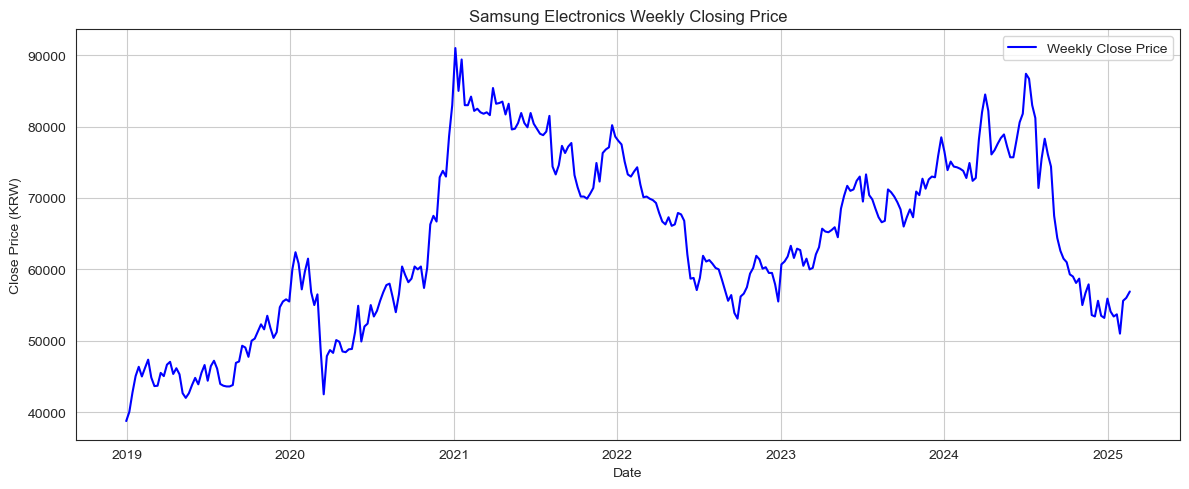

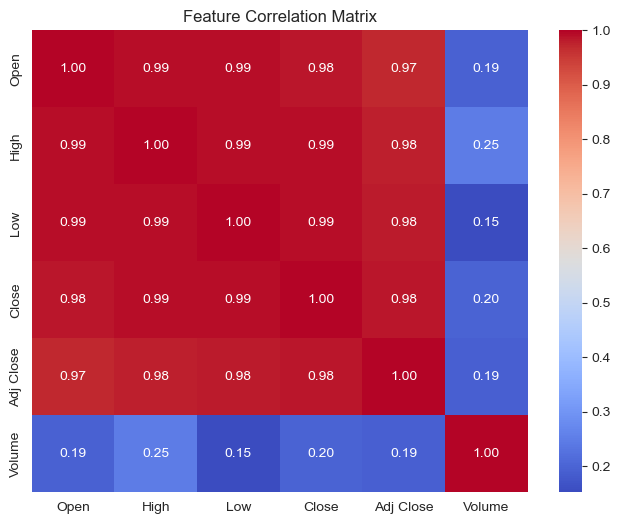

In [1444]:
print("\nData Info:")  # viewing data info
print(df.info())
print("\nData Description:")
print(df.describe())

# close price
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Weekly Close Price', color='blue')
plt.title('Samsung Electronics Weekly Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Corr heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()


# Check for skewness

In [1445]:
for col in df:
    print(f'{col} = {df[col].skew()}')

Open = -0.05309513191216341
High = -0.002625955420853677
Low = -0.07029570135847463
Close = -0.03434128633778947
Adj Close = -0.2213812583808615
Volume = 1.4407122409222641


In [1446]:
df['Volume_fixed'] = np.sqrt(df['Volume']) #fixing the skewness of Volume

In [1447]:
for col in df:
    print(f'{col} = {df[col].skew()}')

Open = -0.05309513191216341
High = -0.002625955420853677
Low = -0.07029570135847463
Close = -0.03434128633778947
Adj Close = -0.2213812583808615
Volume = 1.4407122409222641
Volume_fixed = -0.12480395693190623


# Feature Engineering

In [1448]:
# Creating Lag features, they contain previous weeks data
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)

#Price differences they take the a certain weeks closing price and deducts the previous weeks closing price from it
df['Close_diff1'] = df['Close'] - df['Close_lag1']
df['Close_diff2'] = df['Close_lag1'] - df['Close_lag2']
df['Close_diff3'] = df['Close_lag2'] - df['Close_lag3']

#volume lag in other words last weeks volume
df['Volume_lag1'] = df['Volume'].shift(1)

#moving averages of close prices
df['Close_ma3'] = df['Close'].rolling(window=3).mean()
df['Close_ma5'] = df['Close'].rolling(window=5).mean()

#percentage change or closing price over a time of 1 week
df['Return_1w'] = df['Close'].pct_change(1)

#drop NaN values that could have been created
df.dropna(inplace=True)

# Creating Target Variable

In [1449]:
df['Target'] = df['Close'].shift(-1) # -1 because we want to predict next weeks price
df.dropna(inplace=True)

# Features and target

In [1450]:
feature_cols = ['Open', 'High', 'Low', 'Close', 'Volume_fixed', 'Close_lag1', 'Close_lag2', 'Close_lag3', 'Close_diff1', 'Close_diff2', 'Close_diff3', 'Close_ma3', 'Close_ma5', 'Return_1w']
X = df[feature_cols]
y = df['Target']

# Create data train and testing split

In [1451]:
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# Basic ML models

## Linear regression

In [1452]:
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)


## Random Forest

In [1453]:
rf = RandomForestRegressor(n_estimators=100, random_state=42)


In [1454]:
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)

# Evaluating models

In [1455]:
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R^2 Score:", r2_score(y_true, y_pred))

In [1456]:
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest (Tuned)", y_test, y_pred_rf)


Linear Regression Evaluation:
MAE: 2097.544345435692
RMSE: 2891.755064586064
R^2 Score: 0.9252526566560764

Random Forest (Tuned) Evaluation:
MAE: 2234.9140625
RMSE: 2938.634624622675
R^2 Score: 0.9228094856713781


# plotting Actual vs predicted prices

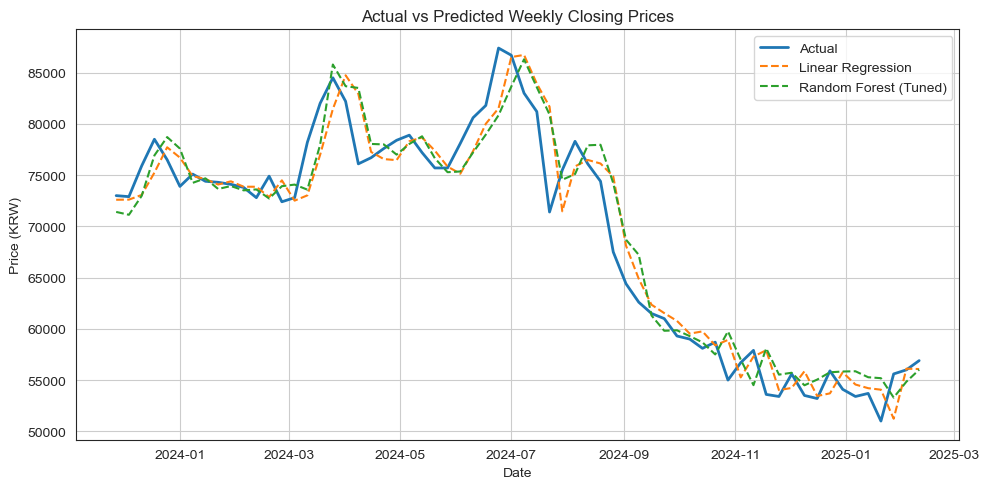

In [1457]:
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred_lr, label='Linear Regression', linestyle='--')
plt.plot(y_test.index, y_pred_rf, label='Random Forest (Tuned)', linestyle='--')
plt.title('Actual vs Predicted Weekly Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (KRW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Random forest importances

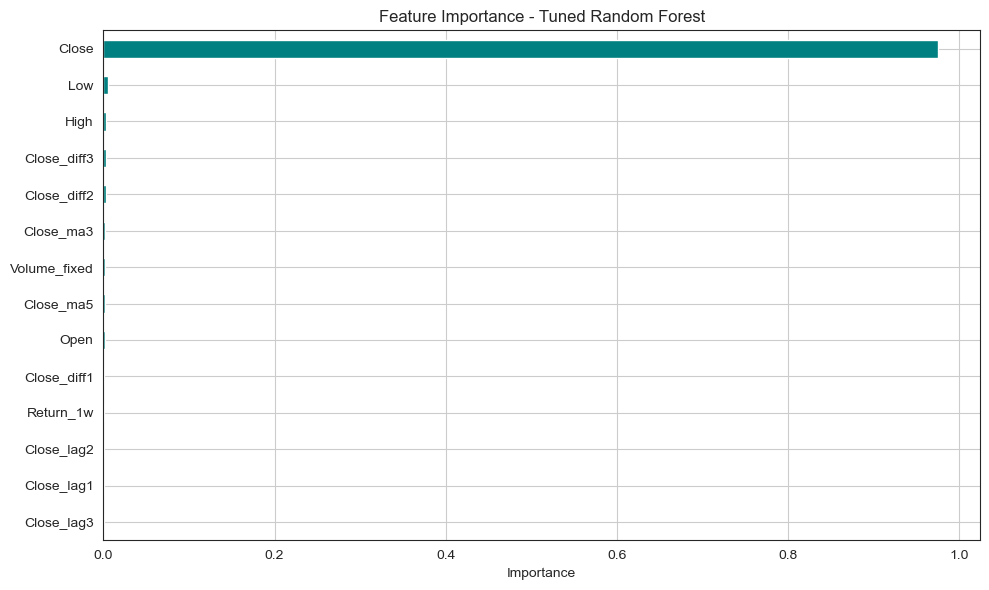

In [1458]:
importances = pd.Series(best_rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='teal')
plt.title('Feature Importance - Tuned Random Forest')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()

NaNs before handling:
Open         1
High         1
Low          1
Close        1
Adj Close    1
Volume       1
dtype: int64

Data Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 321 entries, 2018-12-31 to 2025-02-18
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       321 non-null    float64
 1   High       321 non-null    float64
 2   Low        321 non-null    float64
 3   Close      321 non-null    float64
 4   Adj Close  321 non-null    float64
 5   Volume     321 non-null    float64
dtypes: float64(6)
memory usage: 17.6 KB
None

Data Description:
               Open          High           Low        Close     Adj Close  \
count    321.000000    321.000000    321.000000    321.00000    321.000000   
mean   64121.339564  65683.956386  62565.732087  64066.35514  59895.032941   
std    12312.175291  12481.302250  12026.239288  12175.65471  12804.068612   
min    38000.000000  39400.000000  36850.00

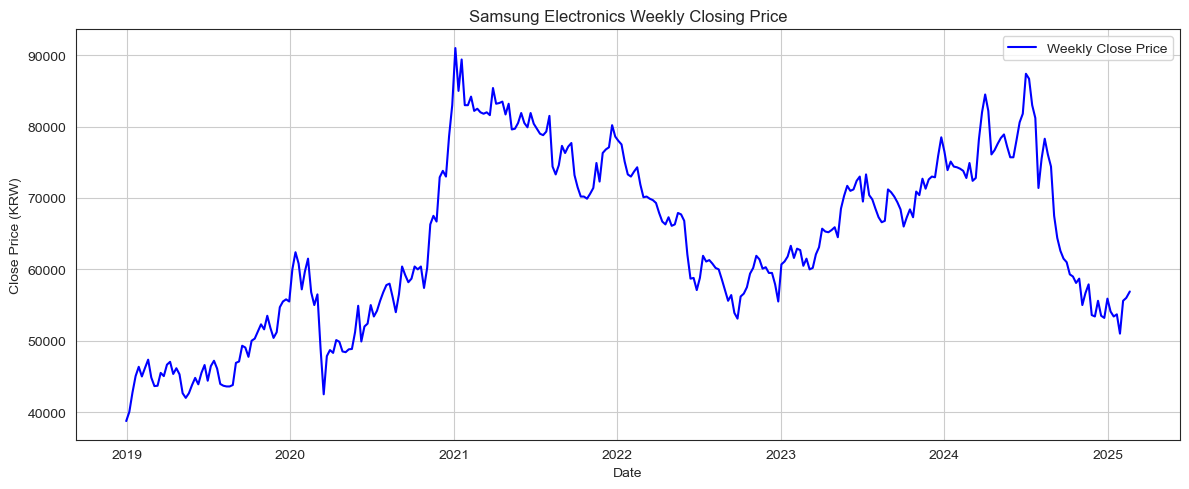

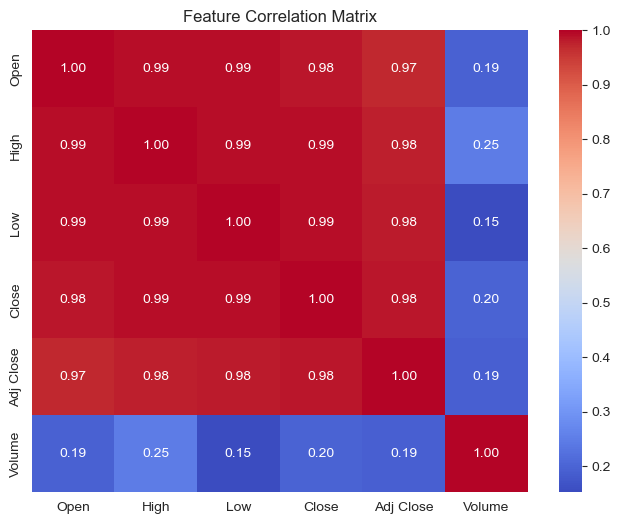


Linear Regression Evaluation:
MAE: 2097.544345435692
RMSE: 2891.755064586064
R^2 Score: 0.9252526566560764

Random Forest (Tuned) Evaluation:
MAE: 2234.9140625
RMSE: 2938.634624622675
R^2 Score: 0.9228094856713781


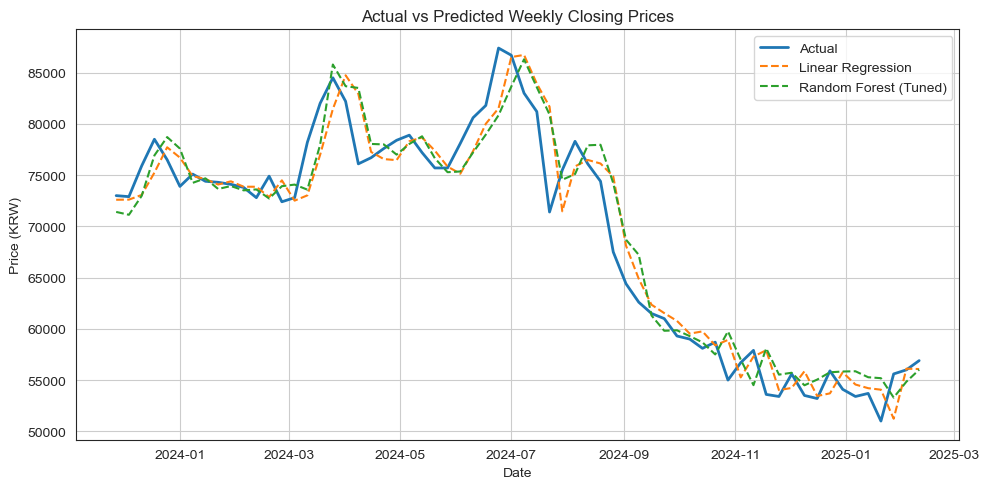

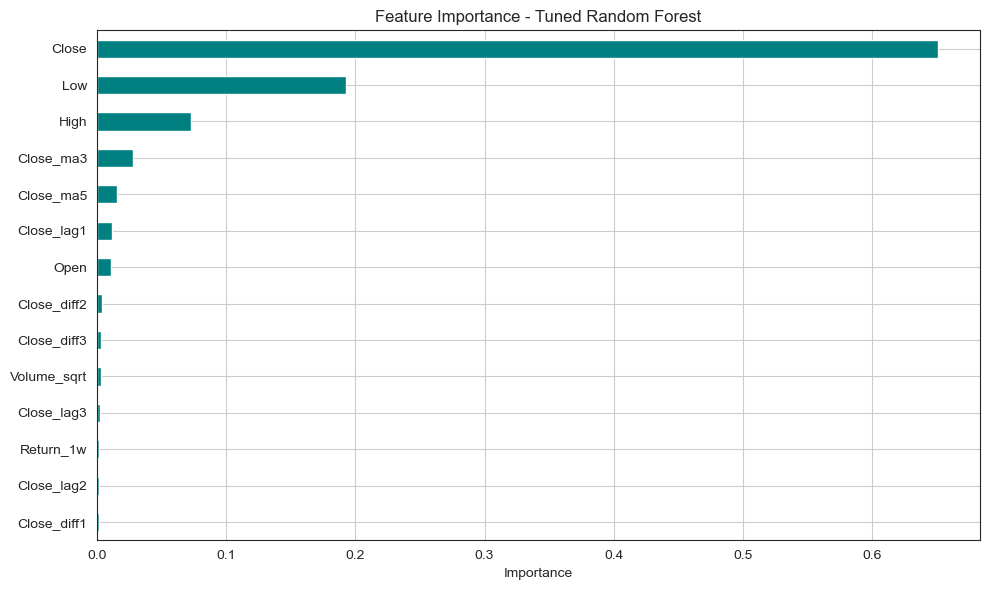

In [1459]:
# Stock Price Prediction Using Weekly Data (Samsung Electronics)

# --------------------
# 📦 1. Import Libraries
# --------------------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# --------------------
# 📥 2. Load Data
# --------------------
df = pd.read_csv('../Data/005930.KS_weekly.csv')
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values('Date', inplace=True)
df.set_index('Date', inplace=True)

# Check for duplicates
df = df[~df.index.duplicated()]

# Check for missing values
print("NaNs before handling:")
print(df.isna().sum())

# Drop rows with any NaN values (safe choice for weekly data)
df.dropna(inplace=True)

# --------------------
# 📊 3. Exploratory Data Analysis (EDA)
# --------------------
print("\nData Info:")
print(df.info())
print("\nData Description:")
print(df.describe())

# Plot closing price
plt.figure(figsize=(12, 5))
plt.plot(df['Close'], label='Weekly Close Price', color='blue')
plt.title('Samsung Electronics Weekly Closing Price')
plt.xlabel('Date')
plt.ylabel('Close Price (KRW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(df.corr(), annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Feature Correlation Matrix")
plt.show()

# --------------------
# ⚙️ 4. Feature Adjustment (Volume Skew Fix)
# --------------------
df['Volume_sqrt'] = np.sqrt(df['Volume'])

# Lag Features
df['Close_lag1'] = df['Close'].shift(1)
df['Close_lag2'] = df['Close'].shift(2)
df['Close_lag3'] = df['Close'].shift(3)

# Price Momentum (Differences)
df['Close_diff1'] = df['Close'] - df['Close_lag1']
df['Close_diff2'] = df['Close_lag1'] - df['Close_lag2']
df['Close_diff3'] = df['Close_lag2'] - df['Close_lag3']

df['Volume_lag1'] = df['Volume_sqrt'].shift(1)

# Moving Averages
df['Close_ma3'] = df['Close'].rolling(window=3).mean()
df['Close_ma5'] = df['Close'].rolling(window=5).mean()

# Return-based Feature
df['Return_1w'] = df['Close'].pct_change(1)

# Drop resulting NaNs from new features
df.dropna(inplace=True)

# --------------------
# 🎯 5. Create Target Variable
# --------------------
df['Target'] = df['Close'].shift(-1)  # or -3
df.dropna(inplace=True)  # Drop last row without a target

# --------------------
# 🔄 6. Prepare Features & Target
# --------------------
feature_cols = [
    'Open', 'High', 'Low', 'Close', 'Volume_sqrt',
    'Close_lag1', 'Close_lag2', 'Close_lag3',
    'Close_diff1', 'Close_diff2', 'Close_diff3',
    'Close_ma3', 'Close_ma5', 'Return_1w'
]
X = df[feature_cols]
y = df['Target']

# Time-based train-test split (80/20)
split_index = int(len(df) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

# --------------------
# 🤖 7. Modeling: Linear Regression
# --------------------
lr = LinearRegression()
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)

# --------------------
# 🌲 8. Modeling: Random Forest + Tuning
# --------------------
rf = RandomForestRegressor(n_estimators=100, random_state=42)

rf.fit(X_train, y_train)

rf.predict(X_test)

# --------------------
# 📈 9. Evaluation
# --------------------
def evaluate_model(name, y_true, y_pred):
    print(f"\n{name} Evaluation:")
    print("MAE:", mean_absolute_error(y_true, y_pred))
    print("RMSE:", np.sqrt(mean_squared_error(y_true, y_pred)))
    print("R^2 Score:", r2_score(y_true, y_pred))

# Evaluate both models
evaluate_model("Linear Regression", y_test, y_pred_lr)
evaluate_model("Random Forest (Tuned)", y_test, y_pred_rf)

# Plot predictions
plt.figure(figsize=(10, 5))
plt.plot(y_test.index, y_test, label='Actual', linewidth=2)
plt.plot(y_test.index, y_pred_lr, label='Linear Regression', linestyle='--')
plt.plot(y_test.index, y_pred_rf, label='Random Forest (Tuned)', linestyle='--')
plt.title('Actual vs Predicted Weekly Closing Prices')
plt.xlabel('Date')
plt.ylabel('Price (KRW)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# --------------------
# 🔍 10. Feature Importance (Random Forest)
# --------------------
importances = pd.Series(rf.feature_importances_, index=feature_cols)
importances.sort_values(ascending=True).plot(kind='barh', figsize=(10, 6), color='teal')
plt.title('Feature Importance - Tuned Random Forest')
plt.xlabel('Importance')
plt.grid(True)
plt.tight_layout()
plt.show()